In [1]:
# @hidden_cell
""" Bart Gerritsen, Oct 2018:

Note: for safety and robustness, styles and script are contained inside
      the Notebook rather than in external *.css and *.js files
"""      
from IPython.core.display import HTML
from IPython.display import display
tag = HTML('''
<style>
    /*TU color table */
    :root {
      --tu-black:        rgb(0,0,0);
      --tu-white:        rgb(255,255,255);
      --tu-cyan:         rgb(0,166,214);
      --tu-green:        rgb(165,202,26);
      --tu-yellow:       rgb(225,196,0);
      --tu-orange:       rgb(230,70,22);
      --tu-red:          rgb(225,26,26);
      --tu-purple:       rgb(109,23,127);
      --tu-slategreen:   rgb(107,134,137);
      --tu-turqoise:     rgb(0,136,145);
      --tu-darkblue:     rgb(29,28,115);
      --tu-skyblue:      rgb(110,187,213);
    }
    h2, h3, h4 {
        background-color: var(--tu-white);
        color: var(--tu-cyan);
    }
    h1 {
        background-color: var(--tu-cyan);
        color: var(--tu-white);
    }
    em {
        color: var(--tu-cyan);
    }
     
    div.output_stdout {
        background-color: var(--tu-green);
        color: var(--tu-black);
    }
    div.output_stdout:before {
        content: "stdout output;";
    }
    div.output_stderr {
        background-color: var(--tu-yellow);
        color: var(--tu-black);
    }
    div.output_stderr:before {
        content: "stderr output;";
    }
</style>
<script>
    code_show=true; 
    IPython.OutputArea.prototype._should_scroll = function(lines) {
        return false;
    }
    function code_toggle() {
        if (code_show){
            $('div.cell.code_cell.rendered.selected div.input').hide();
        } else {
            $('div.cell.code_cell.rendered.selected div.input').show();
        }
        code_show = !code_show
    }     
    $( document ).ready(code_toggle);
</script>
<a href="javascript:code_toggle()"><h4>Notebook settings</h4></a>
''')
display(tag)

<header>
    <div style="overflow: auto;">
        <img src="./figures/TUDelft.jpg" style="float: left;" />
        <img src="./figures/DUT_Flame.png" style="float: right; width: 100px;" />
    </div>
    <div style="text-align: center;">
        <h2>Graphs, connectedness, shortest path and spanning trees</h2>
        <h6>&copy; 2018, 2019, Bart Gerritsen, TU Delft. Creative Commons</h6>
    </div>
    <br>
    <br>
</header>

# Introduction <a class="anchor" id="introduction"/>

Below, you find Assignment A3, a 2-student team assignment, for which the team has exactly 2 weeks. For this assignment, 80 points can be score altogether, assigning you a grade 8. During the assessment of you work, all team members should be able to explain, demo the work handed in, and answer background questions. During the assessment, you can raise your grade to a 10. On the other hand, assessors may lower the grade or even disqualify your work, in case your understanding of your own work appears poor or insufficient. In case of fraud, assessors will report this to the course responsible, without assigning a grade at all.

Do not Run-all |>|> , as there are some long tasks in this Notebook. Start at the top and run cell-by-cell, advancing downwards.

Note: this Notebook requires also `module PlotGraph`.

# Exercise 1: Undirected Graph

## class Graph<a class="anchor" id="class_graph"/>
The `class Graph` we will be using in this assignments, implements both undirected and directed graphs (a.k.a. digraphs). To make a graph a digraph, set the `directed` flag to `True`. Furthermore, the `Graph` class splits off node geometry from node adjacency information.

In [61]:
class Graph:
    """implements a two dictionary-based (directed) graph of nodes and edges"""
    
    def __init__(self, vtx_dict={}, adj_dict = {}, directed=False):
        '''construct a graph from the dictionaries for geometry and topology'''
        self.vtx_dict = vtx_dict # contain node positions, colors
        self.adj_dict = adj_dict # contains weighted edge info only
        self.directed = directed # flag if digraph

    def __str__(self):
        '''return a string representation of self'''
        connected, M = self.get_matrix()
        S = '\n'.join([''.join(['{:4}'.format(item) for item in row]) for row in M])
        cat_string = '' + ('Connected' if connected else 'unconnected') + ' ' + \
                          ('digraph' if self.directed else 'undirected graph')
        return "\n"+S+"\n" + cat_string
    
    def get_matrix(self): #undirected only
        '''return adjacency matrix with connected T|F'''
        def _connected(mat):
            '''return T|F graph if matrix connected'''
            if mat is None:
                return False
            else:
                connSet = set([0]) #connectivitySet
                traverseNode(mat,0,connSet)
                return len(connSet) == len(mat)
        
        def traverseNode(mat, node, connectivitySet):
            for j in range(len(mat)):
                if mat[node][j]:
                    connectivitySet.add(j)
                    mat[node][j] = 0
                    traverseNode(mat, j,connectivitySet)
                    
            
        # derive the adjacency matrix
        mat = [[self.get_edge_weight(i,j) \
                for j in self.nodes()] for i in self.nodes()]
        cmat = [[self.get_edge_weight(i,j) \
                for j in self.nodes()] for i in self.nodes()]
        
        connected = _connected(mat)
        return connected, cmat
    
    def nodes(self):
        '''return all nodes in the vtx dict'''
        return list(self.vtx_dict.keys())

    def edges(self, node):
        '''return list of neighbors connected to node'''
        return self.adj_dict[node]
        
    def all_edges(self):
        '''return a list of all unique edges'''
        all_edges = set()
        for edge_from in self.nodes():
            for edge_to in self.edges(edge_from):
                # add a tuple (edge_from, edge_to, weight) to the all edges set 
                all_edges.add((edge_from, edge_to, self.adj_dict[edge_from][edge_to]))
        return list(all_edges)
    
    def get_edge_weight(self, node_a, node_b):
        '''return the weight of edge node_a to _idB'''
        return self.adj_dict.get(node_a).get(node_b, 0)
    
    def add_node(self, node_id, geom_props={}):
        '''add a new node with given id to the graph'''
        self.vtx_dict[node_id] = geom_props
        self.adj_dict[node_id] = {}
        return self
    
    def add_edge(self, node_a, node_b, weight = 1):
        '''insert a new weighted edge node A to B'''
        def _create_edge(node_a, node_b, weight = 1):
            '''insert edge A to B, weight w in node dict A'''
            node_a_connections = self.adj_dict[node_a]
            node_a_connections.update({node_b:weight})
            self.adj_dict.update({node_a:node_a_connections})
        
        _create_edge(node_a, node_b, weight)
        # depending on graph being directed or not, we also create ...
        if not self.directed:
            _create_edge(node_b, node_a, weight)
    
    def remove_node(self, node_id):
        '''remove node with given id and all its adjacent edges'''
        connections = self.adj_dict[node_id]
        for node_adj in set(connections):
            del self.adj_dict[node_id][node_adj]
            del self.adj_dict[node_adj][node_id]
        del self.vtx_dict[node_id]
        
    def remove_edge(self, node_a, node_b):
        '''del edge from node_a onto node_b from node A dict'''
        del self.adj_dict[node_a][node_b]
        # depending on graph being directed or not, we also del ...
        if not self.directed:
            del self.adj_dict[node_b][node_a]
        

#### Task 1.1: create an undirected graph
Complete the below dictionaries by adding nodes `'v6'` with position `x=2.5` and `y=0.5` and color red, and `'v7'` with position `x=3.5` and `y=0.5` with color pink. Then, add edges `'v6' to 'v0'` with weight `2`, to `'v2'` with weight `3`, to `'v6' to 'v4'` with weight `2`, and finally to `'v5'` with weight `1`. For `'v7'` add an edge `'v7' to 'v0'` with weight `1`. Does the order of nodes within an edge matter?

In [57]:
# Task 1.1 code cell 

def make_graph():
    ''' return the graph as in the above diagram'''

    # geometry and appearance ...
    vtx_dict = {
        'v0': {'pos': [1.5,2.0], 'color': 'cyan'},
        'v1': {'pos': [2.3,0.5], 'color': 'orange'},
        'v2': {'pos': [3.0,1.5], 'color': 'orange'},
        'v3': {'pos': [4.0,2.0], 'color': 'grey'},
        'v4': {'pos': [2.5,3.0], 'color': 'orange'},
        'v5': {'pos': [2.0,4.0], 'color': 'blue'},
        'v6': {'pos': [2.5,0.5], 'color': 'red'}, # our code
        'v7': {'pos': [3.5,0.5], 'color': 'pink'} # our code
    }

    adj_dict = {
        'v0': {'v1':2, 'v2':1, 'v6':2, 'v7':1},
        'v1': {'v0':2},
        'v2': {'v0':1, 'v3':1, 'v4':2, 'v6':3},
        'v3': {'v2':1, 'v4':1},
        'v4': {'v2':2, 'v3':1, 'v6':1}, #corrected to weight of edge v4-v6 to 1 (typo in exercise)
        'v5': {'v6':1},
        'v6': {'v0':2, 'v2':3,'v4':1,'v5':1}, #our code #note to self; edge v6-v4 has weight 2, but edge v4-v6 has weight 1
        'v7': {'v0':1} #our code
    }
    
    graph = Graph(vtx_dict, adj_dict)

    return graph

def test_create_graph():
    '''test creating a undirected graph'''
    graph = make_graph()

    # get all nodes and all edges of one of the nodes ...
    nodes_in_graph = graph.nodes()
    edges_node_v4  = graph.edges('v4')
    all_edges      = graph.all_edges()

    print(f'all the nodes in  graph: {str(nodes_in_graph):s}')
    print(f'v4 has edges connecting: {str(edges_node_v4):s}')
    print(f'all edges in the graph : {str(all_edges):s}')
    
test_create_graph()


all the nodes in  graph: ['v0', 'v1', 'v2', 'v3', 'v4', 'v5', 'v6', 'v7']
v4 has edges connecting: {'v2': 2, 'v3': 1, 'v6': 1}
all edges in the graph : [('v0', 'v6', 2), ('v7', 'v0', 1), ('v5', 'v6', 1), ('v2', 'v6', 3), ('v6', 'v0', 2), ('v4', 'v6', 1), ('v0', 'v2', 1), ('v6', 'v5', 1), ('v2', 'v3', 1), ('v4', 'v3', 1), ('v6', 'v2', 3), ('v1', 'v0', 2), ('v0', 'v7', 1), ('v4', 'v2', 2), ('v6', 'v4', 1), ('v3', 'v4', 1), ('v3', 'v2', 1), ('v0', 'v1', 2), ('v2', 'v0', 1), ('v2', 'v4', 2)]


#### Task 1.2: plot the graph
Plot the graph created using the below code

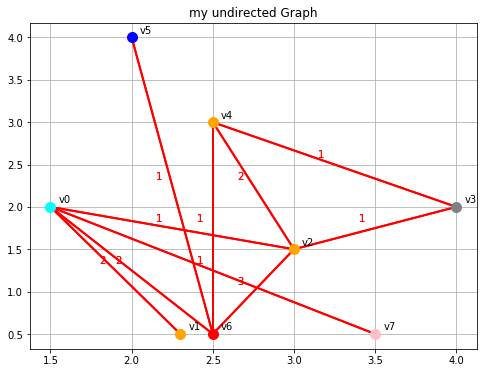

In [58]:
# if not working OK on your computer, change `qt` into `inline`
%matplotlib inline

# import module to plot graph ...
from PlotGraph import plot_graph

# also want a plot?
DO_PLOT = True

# make a graph using function `make_graph()` and plot it ...
my_graph = make_graph()

# get edges for each source node and test if valid node ...
for src_node in my_graph.adj_dict.keys():
    edg_list = my_graph.edges( src_node )
    for dest_node in edg_list:
        assert dest_node in my_graph.adj_dict[src_node], 'edge (source-dest) not found in adj. dictionary'

plot_graph(my_graph, 'my undirected Graph', DO_PLOT)

#### Task 1.3: add and remove nodes and edges
Complete member function `Graph.add_edge()` and `Graph.remove_edge()`.  Run the below test program to verify your code. Next, finalize member functions  `Graph.add_node()`, function `Graph.remove_node()`. 

In the below code, ad or remove:

* `add_edge('v1', 'v2', weight=2)`
* `add_node('v8', {'pos': [1.4, 0.8], 'color': 'purple'})`
* `add_edge('v8', 'v7', 3)`
* `add_edge('v8', 'v1', 1)`
* `remove_edge('v1', 'v2')`
* `remove_node('v8')`

Inspect the graph graphically in the plot created (make sure to inspect the right plot!)

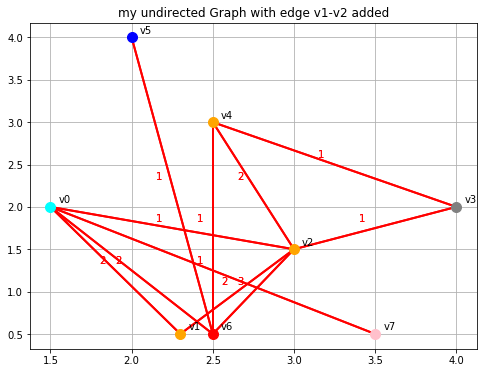

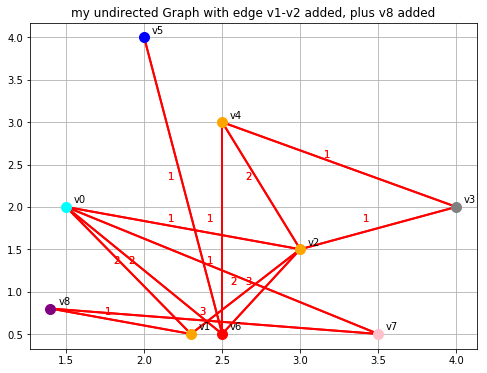

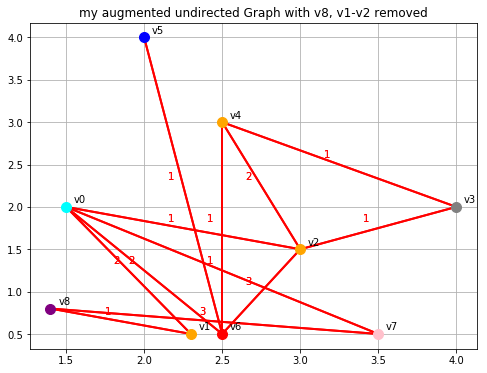

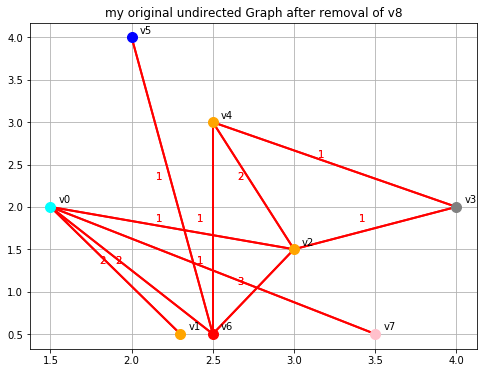

In [59]:
# Task 1.3 code cell

DO_PLOT = True

def test_add_remove_nodes_edges():
    '''test adding and removing nodes and edges'''
    my_graph = make_graph()
    
    # add edge ('v1', 'v2', weight=2) ...
    my_graph.add_edge('v1','v2', weight=2)
    
    # ... plot graph for inspection ...
    plot_graph(my_graph, 'my undirected Graph with edge v1-v2 added', DO_PLOT)
    
    # add node ('v8', {'pos': [1.4, 0.8], 'color': 'purple'}) ...
    my_graph.add_node('v8', {'pos': [1.4, 0.8], 'color': 'purple'})
    
    # ... add edges ('v8', 'v7', 3) and ('v8', 'v1', 1)...
    my_graph.add_edge('v8', 'v7', 3)
    my_graph.add_edge('v8', 'v1', 1)
        
    # ... plot the graph for inspection ...
    plot_graph(my_graph, 'my undirected Graph with edge v1-v2 added, plus v8 added', DO_PLOT)
    
    # ... remove edge ('v1', 'v2') ...
    my_graph.remove_edge('v1','v2')
    
    # ... plot the graph for inspection ...
    plot_graph(my_graph, 'my augmented undirected Graph with v8, v1-v2 removed', DO_PLOT)
    
    # ... remove node ('v8') ... (with all edge connected to it) ...
    my_graph.remove_node('v8')
    
    # ... plot the graph for inspection ...
    plot_graph(my_graph, 'my original undirected Graph after removal of v8', DO_PLOT)

test_add_remove_nodes_edges()

#### Task 1.4.1 connected adjacency matrix
Finalize the inner function `_connected()` in `Graph.get_matrix()` function, that computes the graph's connectedness based on the adjacency matrix. Use the below test code to verify your results. Observe that the below test code prints the graph's matrix using `Graph.__str__()`, which prints a connected|unconnected flag below the matrix

In [62]:
# Task 1.4.1 code cell
def test_is_connected_matrix():
    print('Test if graph is connected, by matrix analysis')

    # make a new graph ...
    my_graph = make_graph()
    
    # check the diagram: clearly connected ... let's check ...
    connected0, matrix = my_graph.get_matrix()
    print(f'graph adjacency matrix (connected (0): {connected0}); {str(my_graph):s}\n')
    assert connected0 == True, 'graph was unexpectedly found unconnected'
    
    # ... now remove edge v0-v6 ...
    my_graph.remove_edge('v0', 'v6')
    connected1, matrix = my_graph.get_matrix()
    print(f'graph adjacency matrix (connected (1): {connected1}); {str(my_graph):s}\n')
    # ... graph should remain connected .... let's check ...
    assert connected1 == True, 'graph unexpectedly found unconnected, after removing v0-v6'
    
    # ... now also remove v5-v6 ... 
    my_graph.remove_edge('v5', 'v6')
    connected2, matrix = my_graph.get_matrix()
    print(f'graph adjacency matrix (connected (2): {connected2}); {str(my_graph):s}\n')
    # assert the result to be correct, like above ...
    assert connected2 == False, 'graph unexpectedly found connected, after removing v5-v6'
    
    # ... remove node v5 ...
    my_graph.remove_node('v5')
    connected3, matrix = my_graph.get_matrix()
    print(f'graph adjacency matrix (connected (3): {connected3}); {str(my_graph):s}\n')
    # assert the result to be correct, like above ... 
    assert connected3 == True, 'graph unexpectedly found unconnected, after removing v5'
    
    # ... when arriving here ...
    print('tests completed succesfully')
    
## run the test ...  
test_is_connected_matrix()

Test if graph is connected, by matrix analysis
graph adjacency matrix (connected (0): True); 
   0   2   1   0   0   0   2   1
   2   0   0   0   0   0   0   0
   1   0   0   1   2   0   3   0
   0   0   1   0   1   0   0   0
   0   0   2   1   0   0   1   0
   0   0   0   0   0   0   1   0
   2   0   3   0   1   1   0   0
   1   0   0   0   0   0   0   0
Connected undirected graph

graph adjacency matrix (connected (1): True); 
   0   2   1   0   0   0   0   1
   2   0   0   0   0   0   0   0
   1   0   0   1   2   0   3   0
   0   0   1   0   1   0   0   0
   0   0   2   1   0   0   1   0
   0   0   0   0   0   0   1   0
   0   0   3   0   1   1   0   0
   1   0   0   0   0   0   0   0
Connected undirected graph

graph adjacency matrix (connected (2): False); 
   0   2   1   0   0   0   0   1
   2   0   0   0   0   0   0   0
   1   0   0   1   2   0   3   0
   0   0   1   0   1   0   0   0
   0   0   2   1   0   0   1   0
   0   0   0   0   0   0   0   0
   0   0   3   0   1   0   0 

#### Task 1.4.2 connectedness form graph traversal
Next, finalize the below static Boolean method function `Graph.connected()` to compute the graph being connected or not, by traversing it. Use the below test code to verify your implementation. Compare the results with the results in the previous test based on the adjacency matrix

In [100]:
# Task 1.4.2 code cell

class Graph(Graph):
    
    @staticmethod
    def connected(graph, visited=None, start=None):
        '''returns T|F graph connected'''
        nodes = graph.nodes()
        if visited is None:
            visited = set()
        if start is None:
            # choose a starting point
            start = nodes[0]
        visited.add(start)
        
        # as long as not yet done ...
        if len(visited) != len(nodes):
            # find all nbors i can visit ...
            for node in graph.adj_dict[start].keys():
                # ... if not yet visited ...
                if not node in visited:
                    # ... recursively visit them ...
                    # ... and return if connected ...
                    if Graph.connected(graph, visited, node):
                        return True
        else:
            # could visit all nodes ...
            return True
        
        # by here, we could not reach at least one node ...
        return False
        

    
# --- test your code below ----------------------------------------------------------------

def test_connectedness():
    '''test the connected static function member'''
    # use make graph from the previous question ...
    my_graph = make_graph()
    
    # check the diagram: clearly connected ... let's check ...
    x = Graph.connected(my_graph)
    print(x)
    assert x == True, 'graph was unexpectedly found unconnected'
    
    # ... now remove edge v0-v6 ...
    my_graph.remove_edge('v0', 'v6')
    # ... graph should remain connected .... let's check ...
    assert Graph.connected(my_graph) == True, 'graph unexpectedly found unconnected, after removing v0-v6'
    
    # ... now also remove v5-v6 ... 
    my_graph.remove_edge('v5', 'v6')
    # assert below if the result is correct, like above ...
    assert Graph.connected(my_graph) == False, 'graph unexpectedly found connected, after removing v5-v6'
    
    # ... remove node v5 ...
    my_graph.remove_node('v5')
    # assert below if the result is correct, like above ...
    assert Graph.connected(my_graph) == True, 'graph unexpectedly found unconnected, after removing v5'
    
    
    # ... when arriving here ...
    print('tests completed succesfully')
    
test_connectedness()

True
tests completed succesfully


#### Task 1.5: breadth-first searching a path
Using the BFS path traversal functions (see the slides), implement a breadth-first search for a path from a *start* node to a *target* node, in static method `Graph.breadth_first_search()` below. Test your implementation using the below function `test_path_breadth_first()`. Do not change function or variable names in the skeleton code

In [102]:
# Task 1.5 code cell

class Graph(Graph):
    
    @staticmethod
    def breadth_first(graph, start, target):
        '''return path from source to target, using BFS, none if not on graph'''
        
        def _initialize_bfs(graph, start = None):
            '''return initial node properties and queue for BFS search'''
            search_node_props = {}
            nodes = graph.nodes()
            for node in nodes:
                search_node_props[node] = {
                    "color": "white",
                    "distance": float('inf'),
                    "parent": None
                }
            
            # set the color of the start node to "gray" ...
            # ... the distance to 0 and the parent to None ...
            if start==None:
                start=nodes[0]
            search_node_props[start] = {
                    "color": "grey",
                    "distance": 0,
                    "parent": None
                }
            
            # create a Q (a list) containing just the start node ...
            Q = [start]

            return search_node_props, Q
        
        def bfs(graph, start):
            '''return nodes in start-to-target path, using BFS search'''
            nodes, queue = _initialize_bfs(graph, start)
            while queue:
                # get start node from queue ...
                u = queue.pop(0)
                # ... try to add nodes v to path so far, from u ...
                for v in graph.adj_dict.get(u).keys():
                    if v not in ['pos']:
                        if nodes[v]["color"] == "white":
                            # ... update the properties ...
                            nodes[v] = {
                                "color":"gray",
                                "distance": nodes[u]["distance"] + 1,
                                "parent": u
                            }
                            # add it to the path so far ...
                            queue.append(v)
                # done with node u ... set its color "black" ...
                nodes[u]["color"] = "black"
            return nodes

        # bfs main part ...
        nodes = bfs(graph, start)
        current = target
        path = []
        # remember parent to be able to back-track ...
        while nodes[current]["parent"]:
            path.append(nodes[current]["parent"])
            current = nodes[current]["parent"]
        # rturn the path found ...
        return path


# --- TEST your code below ---------------------------------------------------------------------------------

def test_path_breadth_first(start, target):
    print('Test find path start-to-target breadth first')
    
    # make a new graph ...
    my_graph = make_graph()

    # find path start->target ...
    path = Graph.breadth_first(my_graph, start, target)
    
    # now print the entire path start->target...
    path_as_string = ' -> '.join( list(reversed(path)) + list([ target ]) )
    print(f'bfs path {start:s} --> {target:s} found: {path_as_string:s}')

## run the test ...
start, target =  ('v5', 'v1')
test_path_breadth_first(start, target)

Test find path start-to-target breadth first
bfs path v5 --> v1 found: v5 -> v6 -> v0 -> v1


#### Task 1.6: determine the minimum spanning tree using Kruskal
In oder to implement Kruskal we need the following functionality:
1. a list of nodes to be connected in a spanning tree
2. a edge object and a priority queue to obtain the least-weight edges first
3. a function to check if a cycle results when we insert a given edge
4. a function to verify connectedness

The functionality of 1. has already been implemented in the `class Graph`, as well as 4. Therefore, we will first do 2. and 3. and then implement the whole of Kruskal.

#### Task 1.6.1 implement a class of edges that can be ordered by their weight
Finalize the below `class EdgeTpl` we use to implement edge tuples like `('v0', 'v6', 2)` in a orderable way, so that the priority queue can keep them in heap-order, and pop them in increasing order of their weight. Key is to implement their comparison operators `EdgeTpl.__eq__()` and `EdgTpl.__lt__()`. After implementing these, Python is able to compute the result of operations like: `edge_tuple_1 == edge_tuple_2` and: `edge_tuple_1 < edge_tuple_2` for any pair of edge tuples `edge_tuple_1, edge_tuple_2`. We test them using Python's `sorted()` on a list, arguing that if that works, `EdgeTpl` objects can be ordered in the Priority Queue too

In [ ]:
# Task 1.6.1 code cell

class EdgeTpl(tuple):
    """implement a sortable edge tuple (id_a, id_b, weight)"""
    
    def __init__(self, edge_tuple):
        super().__init__()
        self.id_from, self.id_to, self.weight = edge_tuple
        
    def __str__(self):
        return str((self.get_edge_id_from(), self.get_edge_id_to(), self.get_edge_weight()))
    
    def get_edge_id_from(self):
        '''return the id of the edge's origin node'''
        return self.id_from
    
    def get_edge_id_to(self):
        '''return the id of the edge's destinaton node'''
        return self.id_to
    
    def get_edge_weight(self):
        '''return the edge weight'''
        return self.weight

    def __eq__(self, other):
        '''return T|F self equal to other (true if equal weights)'''
        # compute and specify the return of the __eq__() function member ...
        # YOUR CODE HERE
        raise NotImplementedError()
    
    def __lt__(self, other):
        '''return T|F self < other (by weight)'''
        # compute and specify the return of the __lt__() function member ...
        # YOUR CODE HERE
        raise NotImplementedError()
    
def test_EdgeTpl():
    """test class EdgeTpl"""
    et_list = [
        EdgeTpl( ('v1', 'v2', 7) ),
        EdgeTpl( ('v2', 'v3', 2) ),
        EdgeTpl( ('v3', 'v4', 1) ),
        EdgeTpl( ('v4', 'v5', 6) ),
        EdgeTpl( ('v5', 'v6', 3) ),
        EdgeTpl( ('v6', 'v7', 3) ),
        EdgeTpl( ('v7', 'v8', 0) ),
        EdgeTpl( ('v8', 'v9', 2) )
    ]
    
    # if this sort works, we can use expressions such as: 
    # EdgeTpl('v2', 'v4',3) < EdgeTpl('v4', 'v5',7) we not
    # only use in the sort, but also need in the PriorityQueue ...
    print(f'edge tuple list, in-order (sort key=weight);')
    for et in sorted(et_list):
        print(f'edge-tuple: {str(et):s}')

test_EdgeTpl()

#### Task 1.6.2 implement the Priority Queue
Finalize the below class implementation of a priority queue that keeps weighted edges (`EdgeTpl` objects) in minimum-weight heap-order. To heapify, we import Python's `module heapq` and use that module's static methods `heapify()` and `heappop()` to implement and use the heap.

In [ ]:
import heapq

class PrioQ(list):
    """implements a priority queue from a list"""
    
    def __init__(self, edge_tpl_list):
        super().__init__(self)
        self.extend(edge_tpl_list)
        heapq.heapify( self )
        
    def __str__(self):
        et_as_str = '\n'.join([str(et) for et in self])
        return '\n' + et_as_str + '\n'
        
    def empty(self):
        ''' return T|F queue is empty'''
        # YOUR CODE HERE
        raise NotImplementedError()
    
    def dequeue(self):
        '''return the next-in-order edge'''
        edge_tpl = None
        if not self.empty():
            edge_tpl = heapq.heappop( self )
        return edge_tpl
            
def test_PrioQ():
    '''test PrioQ object'''
    et_list = [
        EdgeTpl( ('v1', 'v2', 7) ),
        EdgeTpl( ('v2', 'v3', 2) ),
        EdgeTpl( ('v3', 'v4', 1) ),
        EdgeTpl( ('v4', 'v5', 6) ),
        EdgeTpl( ('v5', 'v6', 3) ),
        EdgeTpl( ('v6', 'v7', 3) ),
        EdgeTpl( ('v7', 'v8', 0) ),
        EdgeTpl( ('v8', 'v9', 2) )
    ]
    
    # make PrioQ ...
    # ... create a priority queue `pq` from the `et_list` ...
    # YOUR CODE HERE
    raise NotImplementedError()
    
    print(f'priority queue: {str(pq):s}')
    
    while not pq.empty():
        print(f'next minimum weight in-order edge: {str(pq.dequeue()):s}')

test_PrioQ()

#### Task 1.6.3: test graph to contain a cycle
A tree is a graph without any cycle. This also holds for a spanning tree. Finalize the below method `Graph.cyclic()` that examines the graph for being cyclic, i.e. containing one or more cycles.

In [ ]:
# Task 1.6.3 code cell

class Graph(Graph):
    
    def cyclic(self):
        '''return T|F graph contains cycle(s)'''
        
        def _contains_cycle(graph, queue, node, visited, parent):
            '''return T|F cycle in sub-graph reacheable from node''' 
            # set current node visited  
            visited.add(node)

            #for all vertices adjacent to this node 
            for nbor in graph.adj_dict[node]: 
                # if not yet visited then check recursively for cycle ... 
                if nbor not in visited:
                    # .. recursively check out the environment ...
                    # ... with node as parent and nbor-not-visited as node ...
                    if _contains_cycle(graph, queue, nbor, visited, node): 
                        # what to do if this evaluates to true?
                        # YOUR CODE HERE
                        raise NotImplementedError()
                # if neighbor visited and not parent of current node: cycle!
                elif parent != nbor: 
                    return True
            # else no cycle
            return False
              
        # set all vertices not visited
        queue = self.nodes()
        
        # create an empty set `visited` in which we keep track 
        # of unique visited nodes ...
        # YOUR CODE HERE
        raise NotImplementedError()
        
        # detect cycle in different depth-first paths ... 
        for node in queue:
            if not node in visited:
                if _contains_cycle(self, queue, node, visited, None): 
                    return True
        return False
        
# --- test your code below ----------------------------------------------------------------

DO_PLOT = True

def test_graph_cyclic():
    '''test the connected static function member'''
    # use make graph from the previous question ...
    my_graph = make_graph()
    
    print('is my graph cyclic, i.e. does it contain any cycle?')
    print(f'... initial graph ...  cyclic? {my_graph.cyclic()}')
    
    # remove v2-v4 ...
    my_graph.remove_edge('v2', 'v4')
    print(f'... removing v2-v4 ... cyclic? {my_graph.cyclic()}')
    
    # remove v2-v6 ...
    my_graph.remove_edge('v2', 'v6')
    print(f'... removing v2-v6 ... cyclic? {my_graph.cyclic()}')

    # remove v4-v6 ...
    my_graph.remove_edge('v4', 'v6')
    print(f'... removing v4-v6 ... cyclic? {my_graph.cyclic()}')
    
    # ... plot the graph for inspection ...
    plot_graph(my_graph, 'my Graph without cycles', DO_PLOT)
    
test_graph_cyclic()

#### Task 1.6.4 implement Kruskal
finalize the below code skeleton `Graph.kruskal()` to implement the Kruskal algorithm for the minimum spanning tree. Verify your code using the below test code.

In [ ]:
#### Task 1.6.4; implement Kruskal

class Graph(Graph):
    
    @staticmethod
    def kruskal(graph):
        '''return the minimum spanning tree version of this graph'''
        
        def _add_edge_without_cycle(graph, edge_to_insert):
            '''add an edge if it would not create a cycle, return T|F added'''
            added = True
            # add it to see if it adds up to the MST ...
            orig, dest, w = edge_to_insert
            
            # now add edge to the graph ...
            # ... but only if not causing cyclicity ...
            # ... HINT: add, then check for cyclicity, 
            #           if cyclic remove again ...
            
            # YOUR CODE HERE
            raise NotImplementedError()
            
            return added
    
        # create the result graph with all the nodes to span ...
        MST = Graph(directed=False)
        # ... copy all nodal info but not the connections ...
        for node, geom in graph.vtx_dict.items():
            MST.add_node(node, geom)
        
        # create a priority queue of EdgeTpl ...
        prio_queue = PrioQ( [EdgeTpl(edge) for edge in graph.all_edges()] )
        
        # now pop edges from the prioity queue ...
        connected = False
        while not (prio_queue.empty() or connected):
            next_edge = prio_queue.dequeue()
            # ... if not causing a cycle (tree!) ... add it to the MST ...
            added = _add_edge_without_cycle(MST, next_edge)
            # spanning tree done ? Cheaper: count edges ...
            if Graph.connected(MST):
                # we're done ...
                connected = True
                
        # compute the MST weight from the adjacency matrix ...
        # HINT: if undirected, weight is 2x specified in the dicts ...
        # YOUR CODE HERE
        raise NotImplementedError()
        
        return mst_weight, MST

# --- test code -----------------------------------------------------

DO_PLOT = True

def test_kruskal_MST():
    
    print('Test minimum spanning tree using Kruskal')
    
    # make a new graph ...
    my_graph = make_graph()
    
    # print the original graph ...
    # ... plot the graph for inspection ...
    plot_graph(my_graph, 'my Graph for Kruskal', DO_PLOT)
    # ... print its matrix ...
    print(f'full graph: {str(my_graph):s}')
    
    # ... find the MST plus its weight ...
    # YOUR CODE HERE
    raise NotImplementedError()
    # ... plot the kruskal min spanning tree ...
    title = f'Kruskal MST (weight: {mst_weight})'
    plot_graph(mst_graph, title, DO_PLOT)
    print(f'MST tree: {str(mst_graph):s}')

## run the test ...
test_kruskal_MST()  

#### Task 1.6.5: change the weight and check MST again
Update the weight of edge `'v3'-'v4'` to `3` and run the same test again. What result would you expect? Verify this below.

In [ ]:
# Task 1.6.5 code cell

edge_origin = 'v3'
edge_destination = 'v4'
edge_weight = 3

def test_MST_with_modified_weights(orig, dest, new_weight):
    '''test Kruskal with modified weights'''
    
    # start with a fresh graph (old settings will get lost!)
    my_graph = make_graph()
    
    # update the weights using the above specified `edge_origin` etc. ...
    my_graph.adj_dict[orig][dest] = new_weight
    # what more to do for this undirected graph? 
    if not my_graph.directed:
        # YOUR CODE HERE
        raise NotImplementedError()
    
    # ... find the new MST ...
    mst_weight, mst_graph = Graph.kruskal(my_graph)
    # ... plot the kruskal min spanning tree ...
    title = f'result of Kruskal MST with {edge_origin}-{edge_destination} set to {edge_weight} ' + \
        f'(weight={mst_weight})'
    
    plot_graph(mst_graph, title, DO_PLOT)
    print(f'MST tree: {str(mst_graph):s}')

test_MST_with_modified_weights(edge_origin, edge_destination, edge_weight)

# Exercise 2: Directed Graph
For this exercise, we use the same `class Graph`, but now we set `directed = True`. By here, you must have run the definition of `class Graph`

#### Task 2.1: create a digraph
Create a directed graph following the skeleton given below. Test the code using the below test function `test_create_digraph()` you will have to finish first

In [ ]:
# Task 2.1 code cell

def make_digraph():
    ''' return a digraph as specified'''

    # geometry and appearance ...
    vtx_dict = {
        'v0': {'pos': [0.2,3.0], 'color': 'cyan'},
        'v1': {'pos': [1.2,2.5], 'color': 'orange'},
        'v2': {'pos': [2.7,3.6], 'color': 'orange'},
        'v3': {'pos': [2.5,2.2], 'color': 'grey'},
        'v4': {'pos': [1.1,1.2], 'color': 'orange'},
        'v5': {'pos': [4.0,2.5], 'color': 'blue'},
        'v6': {'pos': [4.5,1.6], 'color': 'red'},
        'v7': {'pos': [5.0,3.5], 'color': 'pink'}
    }

    # graph topology ...
    adj_dict = {
      'v0': {'v1':4},
      'v1': {'v2':2, 'v3':2},
      'v2': {'v5':-2, 'v7':3},
      'v3': {'v4':2, 'v5':3}, # can make this a negative cycle; set v3-v4->-2
      'v4': {'v1':-1},
      'v5': {'v6':4, 'v7':1},
      'v6': {},
      'v7': {'v6':1}
    }

    # create `digraph`, a directed graph ...
    # YOUR CODE HERE
    raise NotImplementedError()

    return digraph


def test_create_digraph():
    '''test creating a undirected graph'''
    digraph = make_digraph()

    # get all nodes and all edges of one of the nodes ...
    nodes_in_digraph = digraph.nodes()
    edges_node_v4    = digraph.edges('v4')
    all_edges        = digraph.all_edges()

    print(f'all the nodes in digraph: {str(nodes_in_digraph):s}')
    print(f'v4  has edges connecting: {str(edges_node_v4):s}')
    print(f'all edges in the digraph: {str(all_edges):s}')
    
test_create_digraph()

#### Task 2.2: print the adjacency matrix of the graph 

In [ ]:
def test_print_adjacency_matrix():
    
    print('directed graph adjacency matrix;')
    
    # implement code to print the adjacency matrix ...
    # YOUR CODE HERE
    raise NotImplementedError()
    
test_print_adjacency_matrix()

#### Task 2.3: plot the directed graph 
Using the below code, plot the directed graph created

In [ ]:
# Task 2.3 code cell

%matplotlib inline

from PlotGraph import plot_graph

# also want a plot?
DO_PLOT = True

def test_plot_digraph():
    '''test plotting the digraph'''
    
    # make a fresh `digraph` using function `make_digraph` and plot it ...
    # YOUR CODE HERE
    raise NotImplementedError()
    
test_plot_digraph()

#### Task 2.4: Bellman-Ford single source all shortest path
Finalize the below function method `Graph.bellman_ford()`. Verify your code using the below test code.

In [ ]:
# Task 2.4 code cell

class Graph(Graph):
    
    def bellman_ford(self, src_node):
        """compute all shortest paths from source node in directed graph"""
        
        # step 1: initialize ...
        nodes = self.nodes()
        nr_nodes = len(nodes)
        dist = {}
        for node in nodes:
            dist[node] = float("Inf")
        dist[src_node] = 0

        # step 2: relaxation while cycling over increasing edge paths
        for k in range(nr_nodes-1):
            # if a shortest path turns out to exist using more edges,
            # relax dist to node using this nr of edges ...
            # (edges can be processed in any order)
            for edge in self.all_edges():
                edge_from, edge_to, edge_weight = edge
                # relax edge, i.e., update with shorter path if possible ...
                # YOUR CODE HERE
                raise NotImplementedError()
                    
        # step 3: report if graph has negative weight cycle (true, if 
        #         even shortest path exists after this guaranteed min)
        for k in range(nr_nodes-1):
            # if a shortest path turns out to exist using more edges,
            # relax dist to node using this nr of edges ...
            for edge in self.all_edges():
                edge_from, edge_to, edge_weight = edge
                # if shorter path still possible, must be a negative cycle ...
                # ... if so, set dist to destination node to `float("-Inf")` ...
                # YOUR CODE HERE
                raise NotImplementedError()
        return dist

# --- Test code ------------------------------------------------------------------

source = 'v0'

def test_bellman_ford(src_node):
    '''test the bellman-ford shortest paths'''
    
    # make a fresh graph ...
    my_digraph = make_digraph()
    
    distances = my_digraph.bellman_ford(src_node)
    print('\nBellman - Ford all shortest paths;')
    for node, dist in distances.items():
        print(f'shortest distance from {src_node:s} to {node:s}: {dist:.0f}')
    
test_bellman_ford(source)

#### Task 2.5: check if graph has cycles
Finalize the below code to report if `my_digraph` contains one or more cycle, so that the correct result is printed. Verify this using the above plot.

In [ ]:
# Task 2.5 code cell

def test_for_cycle():
    
    my_digraph = make_digraph()

    # assume no cycles ...
    has_cycles = False
    
    # verify if has cycles ...
    # YOUR CODE HERE
    raise NotImplementedError()
    
    # print result
    print(f'digraph has cycles? {has_cycles}')
    
    
test_for_cycle()

#### Task 2.6: introduce a negative cycle in the graph
Bellman-Ford can detect negative cycles; cycles that contribute to a negative growth of total path weight. Negative cycles are relevant for practical applications. When detected, Bellman-Ford sets the shortest path to 

In [ ]:
# Task 2.6 code cell

def test_negative_cycle(src_node, neg_edge):
    '''test introduction of negative cycle'''
    
    # original graph
    my_digraph = make_digraph()
    
    # stage 1 ... original graph ...
    distances = my_digraph.bellman_ford(src_node)
    print('\nBellman - Ford, original graph;')
    for node, dist in distances.items():
        print(f'shortest distance from {src_node:s} to {node:s}: {dist:.0f}')
    
    # stage 2 ...
    # ... now make a negative cycle with the below variables ...
    # ... modify the weight with these values to create one ...
    orig, dest, w = neg_edge
    
    # YOUR CODE HERE
    raise NotImplementedError()
    
    distances = my_digraph.bellman_ford(src_node)
    print('\nBellman - Ford negative cycle;')
    for node, dist in distances.items():
        print(f'shortest distance from {src_node:s} to {node:s}: {dist:.0f}')
    

# specify a negative weight for edge 'v3'->'v4' ...
neg_w_edge = ('v3', 'v4', -2)
source     = 'v0'

test_negative_cycle(source, neg_w_edge)

#### Task 2.7: repair the negative cycle with extra edge (1)
We create the same negative cycle as in the previous task, but now add one extra edge `'v0' -> 'v'2'` with weight `1` to the graph, What will be the effect you think? Verify this using the below code.

In [ ]:
# Task 2.7 code cell

def test_circumvent_cycle_1(src_node, neg_edge, xtra_edge):
    '''test introduction of negative cycle'''
    
    # original graph
    my_digraph = make_digraph()
    
    # stage 1 ...
    distances = my_digraph.bellman_ford(src_node)
    print('\nBellman - Ford, original graph;')
    for node, dist in distances.items():
        print(f'shortest distance from {src_node:s} to {node:s}: {dist:.0f}')
    
    # stage 2 ...
    # ... now make a negative cycle ...
    orig, dest, w = neg_edge

    # update the weight a specified ...
    my_digraph.adj_dict[orig][dest] = w
    
    distances = my_digraph.bellman_ford(src_node)
    print('\nBellman - Ford negative cycle;')
    for node, dist in distances.items():
        print(f'shortest distance from {src_node:s} to {node:s}: {dist:.0f}')
        
    # stage 3 ...
    # ... add the extra edge ...
    orig, dest, w = xtra_edge
    my_digraph.add_edge(orig, dest, w)
    distances = my_digraph.bellman_ford(src_node)
    print('\nBellman - Ford edge v0->v2 (weight=1) added;')
    for node, dist in distances.items():
        print(f'shortest distance from {src_node:s} to {node:s}: {dist:.0f}')
        
    # plot it as a directed graph ...
    plot_graph(my_digraph, 'my modified directed Graph (1)', DO_PLOT)

# specify a negative weight for edge 'v3'->'v4' ...
neg_w_edge  = ('v3', 'v4', -2)
# ... add an extra edge `edge_to_add` to add to the digraph ...
# YOUR CODE HERE
raise NotImplementedError()
source      = 'v0'

test_circumvent_cycle_1(source, neg_w_edge, edge_to_add)

#### Task 2.8: repair the negative cycle with extra edge (2)
We create the same negative cycle as in the previous task, and add one extra edge `'v0' -> 'v'2'` with weight `1` to the graph. In addition, we remove edge `('v1', 'v2')` and `('v5', 'v7')`. What will be the effect you think? Verify this using the below code. What if you set the weight in `'v0' -> 'v'2'` to `-2`? Can you explain?

In [ ]:
# Task 2.8 code cell

def test_circumvent_cycle_2(src_node, neg_edge, xtra_edge, out_edge_1, out_edge_2):
    '''test introduction of negative cycle'''
    
    # original graph
    my_digraph = make_digraph()
    
    # stage 1 ...
    distances = my_digraph.bellman_ford(src_node)
    print('\nBellman - Ford, original graph;')
    for node, dist in distances.items():
        print(f'shortest distance from {src_node:s} to {node:s}: {dist:.0f}')
    
    # stage 2 ...
    # ... now make a negative cycle ...
    orig, dest, w = neg_edge

    # update the weight a specified ...
    my_digraph.adj_dict[orig][dest] = w
    
    distances = my_digraph.bellman_ford(src_node)
    print('\nBellman - Ford negative cycle;')
    for node, dist in distances.items():
        print(f'shortest distance from {src_node:s} to {node:s}: {dist:.0f}')
        
    # stage 3 ...
    # ... add the extra edge ...
    orig, dest, w = xtra_edge
    my_digraph.add_edge(orig, dest, w)
    # remove the two edges `out_edge_1`, `out_edge_2` (cancelling 
    # the path over the negative cycle) ...
    # YOUR CODE HERE
    raise NotImplementedError()
    distances = my_digraph.bellman_ford(src_node)
    print('\nBellman - Ford edge v0->v2 (weight=1) added;')
    for node, dist in distances.items():
        print(f'shortest distance from {src_node:s} to {node:s}: {dist:.0f}')
        
    # plot it as a directed graph ...
    plot_graph(my_digraph, 'my modified directed Graph (2)', DO_PLOT)

# specify a negative weight for edge 'v3'->'v4' ...
neg_w_edge  = ('v3', 'v4', -2)
edge_to_add = ('v0', 'v2',  1)

# specify two edges `edge_out_1` and `edge_out_2` 
# to remove from the digraph (see Task) ...
# YOUR CODE HERE
raise NotImplementedError()

source      = 'v0'

test_circumvent_cycle_2(source, neg_w_edge, edge_to_add, edge_out_1, edge_out_2)

# Done